<img src="img/chapter_1/Seth_Weidman.jpg" width=800>

# Motivation

## Many resources to learn about neural networks.

Code / example-based

* PyTorch/TensorFlow documentation

## Example from PyTorch documentation

```python
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
```

## Totally different code-based approach

* **fast.ai**: "You don't need to understand how things work - just run these few lines of code and train a world-class classifier! Then go back later and understand what is going on."

## Mathematical approach

* Explaining Deep Learning with equations
* Best example: **Ian Goodfellow's [Deep Learning book](https://www.deeplearningbook.org)**

# Contents

* Mathematical/conceptual foundations (don't worry)
    * Functions
    * Derivatives
    * Representing functions as computational graphs
    * Computing derivatives of functions when matrices are involved

* Applying this "first principles"-based approach to build a linear regression
* Extending this to build a neural network
    * Connecting this to how neural networks are usually described

# Contents (continued)

* Moving from first principles Deep Learning building blocks to the elements of Deep Learning models
    * Model
    * Optimizer
    * Loss
    * Trainer
* Using this to build Deep Learning models

* Tricks to make Deep Learning models train better 
    * Softmax cross entropy loss
    * Momentum
    * Weight initialization
    * Learning rate decay
    * Dropout

# Contents (time permitting)

* Convolutional neural networks
* Recurrent neural networks
* PyTorch

# Deep Learning from First Principles

In [1126]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray

np.set_printoptions(precision=4)

%matplotlib inline

# Part 1

Note: three ways of thinking about each concept here:

1. Math
2. Code
3. Diagrams

## Functions

### "Math"

$ f(x) = x^2 $

$ \text{ReLU}(x) = \text{max}(x, 0) $

### Code

In [1127]:
def square(x: ndarray) -> ndarray:
    '''
    Square each element in the input ndarray.
    '''
    return np.power(x, 2)

def relu(x: ndarray) -> ndarray:
    '''
    Apply the "ReLU" function to each element in the input ndarray.
    '''
    return np.clip(x, 0, None)

### Diagrams

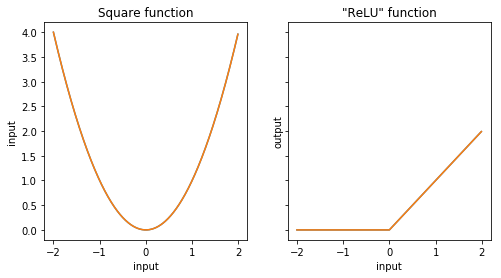

In [1128]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))  # 2 Rows, 1 Col

input_range = np.arange(-2, 2, 0.01)
ax[0].plot(input_range, square(input_range))
ax[0].plot(input_range, square(input_range))
ax[0].set_title('Square function')
ax[0].set_xlabel('input')
ax[0].set_ylabel('input')

ax[1].plot(input_range, relu(input_range))
ax[1].plot(input_range, relu(input_range))
ax[1].set_title('"ReLU" function')
ax[1].set_xlabel('input')
ax[1].set_ylabel('output');

### Functions as "boxes"

<img src="img/chapter_1/02_two_continuous_functions.png" width=500>

## Derivatives

### Diagram

Intuitively: "slope".

But, there's another way to think about derivatives:

<img src="img/chapter_1/03_string_pulling.png" width=300>

But how to compute this?

### Math

To be precise:

$$
\frac{df}{du}(a) =
\lim_{\Delta \to 0} \frac{{f \left( {a + \Delta } \right) - f\left( a - \Delta \right)}}{2 * \Delta }
$$

Can be estimated by:

$$
\frac{df}{du}(a) =
\frac{f(a + 0.001) - f(a - 0.001)}{0.002}
$$

Let's code this up!

### Code

In [1129]:
from typing import Callable

def deriv(func: Callable[[ndarray], ndarray],
          input_: ndarray,
          delta: float = 0.001) -> ndarray:
    '''
    Evaluates the derivative of a function "func" at every element in the "input_" array.
    '''
    return (func(input_ + delta) - func(input_ - delta)) / (2 * delta)

## Nested functions

### Diagram

<img src="img/chapter_1/04_x_f1_f2_y.png" width=400>

<img src="img/chapter_1/05_x_f1f2_y.png" width=400>

Two different ways of representing the same thing!

### Code

In [1130]:
from typing import List

# A Function takes in an ndarray as an argument and produces an ndarray
Array_Function = Callable[[ndarray], ndarray]

# A Chain is a list of functions
Chain = List[Array_Function]

In [1131]:
def chain_length_2(chain: Chain,
                   x: ndarray) -> ndarray:
    '''
    Evaluates two functions in a row, in a "Chain".
    '''
    assert len(chain) == 2, \
    "Length of input 'chain' should be 2"

    f1 = chain[0]
    f2 = chain[1]

    return f2(f1(x))

### Math

Simply: 

$$ 
f_2(f_1(x)) = y
$$ 

## Derivatives of nested functions - or "The Chain Rule"

This turns out to be a very important concept for understanding Deep Learning.

### Diagram

<img src="img/chapter_1/06_chain_rule_illustration_1.png" width=600>

Suggests the chain rule should be a sort of "multiplication"

### Math

A bit unintuitive, but necessary to see:

$ \frac{df_2}{du}(x) = \frac{df_2}{du}(f_1(x)) * \frac{df_1}{du}(x) $

### Code

In [1132]:
def chain_deriv_2(chain: Chain,
                  input_range: ndarray) -> ndarray:
    '''
    Uses the chain rule to compute the derivative of two nested functions:

    '''

    assert len(chain) == 2, \
    "This function requires 'Chain' objects of length 2"

    assert input_range.ndim == 1, \
    "Function requires a 1 dimensional ndarray as input_range"

    f1 = chain[0]
    f2 = chain[1]

    # df1/dx
    f1_of_x = f1(input_range)

    # df1/du
    df1dx = deriv(f1, input_range)

    # df2/du(f1(x))
    df2du = deriv(f2, f1(input_range))

    # Multiplying these quantities together at each point
    return df1dx * df2du

### Testing this code

In [1133]:
def sigmoid(x: ndarray) -> ndarray:
    '''
    Square each element in the input Tensor.
    '''
    return 1 / (1 + np.exp(-x))

#### Plotting code

In [1134]:
def plot_chain(ax,
               chain: Chain, 
               input_range: ndarray) -> None:
    '''
    Plots a chain function - a function made up of 
    multiple consecutive ndarray -> ndarray mappings - across one range
    
    ax: matplotlib Subplot for plotting
    '''
    
    assert input_range.ndim == 1, \
    "Function requires a 1 dimensional ndarray as input_range"

    output_range = chain_length_2(chain, input_range)
    ax.plot(input_range, output_range)

def plot_chain_deriv(ax,
                     chain: Chain,
                     input_range: ndarray) -> ndarray:
    '''
    Uses the chain rule to plot the derivative of two nested functions.
    
    ax: matplotlib Subplot for plotting
    '''
    output_range = chain_deriv_2(chain, input_range)
    ax.plot(input_range, output_range)

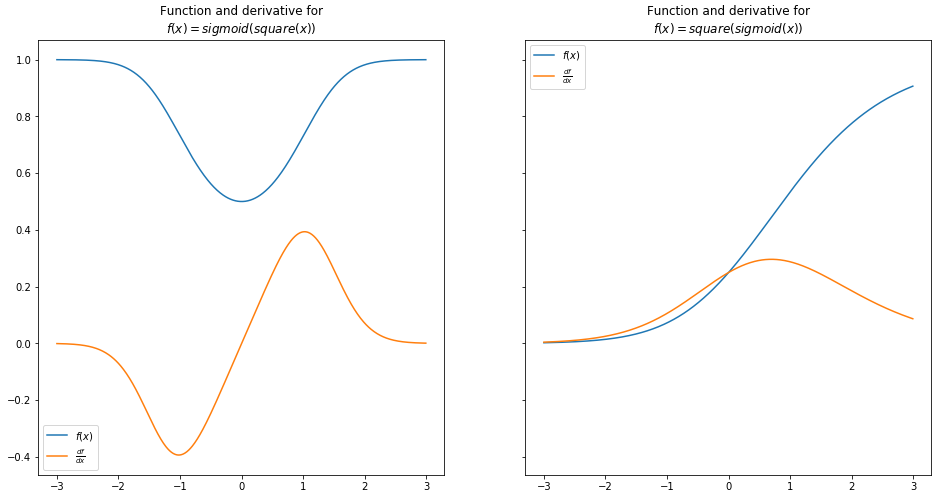

In [1135]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16, 8))  # 2 Rows, 1 Col

chain_1 = [square, sigmoid]
chain_2 = [sigmoid, square]

PLOT_RANGE = np.arange(-3, 3, 0.01)
plot_chain(ax[0], chain_1, PLOT_RANGE)
plot_chain_deriv(ax[0], chain_1, PLOT_RANGE)

ax[0].legend(["$f(x)$", "$\\frac{df}{dx}$"])
ax[0].set_title("Function and derivative for\n$f(x) = sigmoid(square(x))$")

plot_chain(ax[1], chain_2, PLOT_RANGE)
plot_chain_deriv(ax[1], chain_2, PLOT_RANGE)
ax[1].legend(["$f(x)$", "$\\frac{df}{dx}$"])
ax[1].set_title("Function and derivative for\n$f(x) = square(sigmoid(x))$");

## Chain rule with *three* nested functions

### Math

$ \frac{df_3}{du}(x) = \frac{df_3}{du}(f_2(f_1(x))) * \frac{df_2}{du}(f_1(x)) * \frac{df_1}{du}(x)) $

### Code

In [1136]:
def chain_length_3(chain: Chain,
                   x: ndarray) -> ndarray:
    '''
    Evaluates two functions in a row, in a "Chain".
    '''
    assert len(chain) == 3, \
    "Length of input 'chain' should be 3"

    f1 = chain[0]
    f2 = chain[1]
    f3 = chain[2]

    return f3(f2(f1(x)))

In [1137]:
def chain_deriv_3(chain: Chain,
                  input_range: ndarray) -> ndarray:
    '''
    Uses the chain rule to compute the derivative of three nested functions:
    '''

    assert len(chain) == 3, \
    "This function requires 'Chain' objects to have length 3"

    f1 = chain[0]
    f2 = chain[1]
    f3 = chain[2]

    # f1(x)
    f1_of_x = f1(input_range)

    # f2(f1(x))
    f2_of_x = f2(f1_of_x)

    # df3du
    df3du = deriv(f3, f2_of_x)

    # df2du
    df2du = deriv(f2, f1_of_x)

    # df1dx
    df1dx = deriv(f1, input_range)

    # Multiplying these quantities together at each point
    return df1dx * df2du * df3du

### Plotting the results

In [1138]:
def leaky_relu(x: ndarray) -> ndarray:
    '''
    Apply "Leaky ReLU" function to each element in Tensor
    '''
    return np.maximum(0.2 * x, x)

#### Plotting code

In [1139]:
def plot_chain(ax,
               chain: Chain, 
               input_range: ndarray,
               length: int=2) -> None:
    '''
    Plots a chain function - a function made up of 
    multiple consecutive ndarray -> ndarray mappings - across one range
    
    ax: matplotlib Subplot for plotting
    '''
    
    assert input_range.ndim == 1, \
    "Function requires a 1 dimensional ndarray as input_range"
    if length == 2:
        output_range = chain_length_2(chain, input_range)
    elif length == 3:
        output_range = chain_length_3(chain, input_range)
    ax.plot(input_range, output_range)

In [1140]:
def plot_chain_deriv(ax,
                     chain: Chain,
                     input_range: ndarray,
                     length: int=2) -> ndarray:
    '''
    Uses the chain rule to plot the derivative of two nested functions.
    
    ax: matplotlib Subplot for plotting
    '''

    if length == 2:
        output_range = chain_deriv_2(chain, input_range)
    elif length == 3:
        output_range = chain_deriv_3(chain, input_range)
    ax.plot(input_range, output_range)

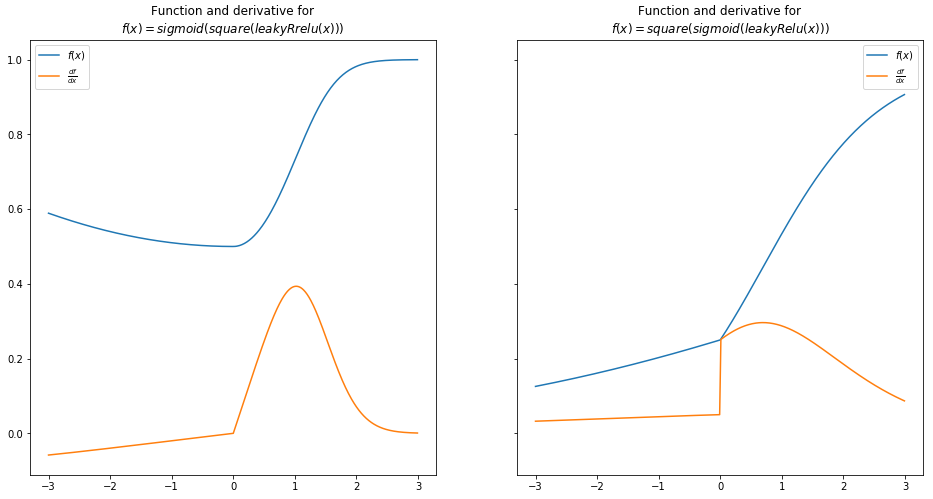

In [1141]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16, 8))  # 2 Rows, 1 Col

chain_1 = [leaky_relu, square, sigmoid]
chain_2 = [leaky_relu, sigmoid, square]

PLOT_RANGE = np.arange(-3, 3, 0.01)
plot_chain(ax[0], chain_1, PLOT_RANGE, length=3)
plot_chain_deriv(ax[0], chain_1, PLOT_RANGE, length=3)

ax[0].legend(["$f(x)$", "$\\frac{df}{dx}$"])
ax[0].set_title("Function and derivative for\n$f(x) = sigmoid(square(leakyRrelu(x)))$")

plot_chain(ax[1], chain_2, PLOT_RANGE, length=3)
plot_chain_deriv(ax[1], chain_2, PLOT_RANGE, length=3)
ax[1].legend(["$f(x)$", "$\\frac{df}{dx}$"])
ax[1].set_title("Function and derivative for\n$f(x) = square(sigmoid(leakyRelu(x)))$");

## Functions with multiple inputs

So far we've been dealing with functions with one input and one output. This works very similarly when we have a function with multiple inputs: we can reason through how much increasing either of these inputs would increase the output.

### Diagram

<img src="img/chapter_1/12_graph_multiple_inputs.png" width=600>

Where $\alpha(x, y)$ is simply $x + y$.

### Math

$ f(x, y) = \sigma(\alpha(x + y)) $

### Code

In [1142]:
def multiple_inputs_add(x: ndarray,
                        y: ndarray,
                        sigma: Array_Function) -> float:
    '''
    Function with multiple inputs and addition
    '''
    assert x.shape == y.shape

    a = x + y
    return sigma(a)

## Derivative of function with multiple inputs

### Diagram

<img src="img/chapter_1/13_function_multiple_inputs_backward.png" width=600>

### Math

$ \frac{\partial f}{\partial x} = \frac{\partial \sigma}{\partial u}(\alpha(x, y)) * \frac{\partial \alpha}{\partial x}((x, y)) = \frac{\partial \sigma}{\partial u}(x + y) * \frac{\partial \alpha}{\partial x}((x, y)) $

If $ \sigma $ is a simple function, it will be easy to compute these quantities.

### Code

In [1143]:
def multiple_inputs_add_backward(x: ndarray,
                                 y: ndarray,
                                 sigma: Array_Function) -> float:
    '''
    Computes the derivative of this function with respect to x and y
    '''
    # Compute "forward pass"
    a = x + y

    # Compute derivatives
    dsda = deriv(sigma, a)

    dadx, dady = 1, 1

    return dsda * dadx, dsda * dady

## Functions with multiple *array* inputs

A very common scenario in Deep Learning is that we have a bunch of features $ X = \begin{bmatrix}x_1 & x_2 & \ldots & x_n\end{bmatrix} $ and we want to create a "weighted combination" of these features, weighting them by some weights $ W = \begin{bmatrix}w_{1}\\w_{2}\\ \vdots \\w_{n} \end{bmatrix} $.

A concise way to express this is as a **dot product** or **matrix multiplication** (these are the same thing in this case since both $ X $ and $ W $ are one-dimensional).

### Math

Mathematically, this looks like:

$ N = \nu(X, W) = X * W  = x_1 * w_1 + x_2 * w_2 + \ldots + x_n * w_n $

### Diagram

<img src="img/chapter_1/16_matrix_multiplication.png" width=400>

### Code

In [1144]:
def matmul_forward(X: ndarray,
                   W: ndarray) -> ndarray:

    assert X.shape[1] == W.shape[0], \
    '''
    For matrix multiplication, the number of columns in the first array should match the
    number of rows in the second, instead the number of columns in the first array is {0}
    and the number of rows in the second array is {1}
    '''.format(X.shape[1], W.shape[0])

    # matrix multiplication
    N = np.dot(X, W)

    return N

## Derivative of vector function

What does this mean?

### Diagram

<img src="img/chapter_1/17_backward_matrix_multiplication.png" width=400>

### Math

Conceptually, we want:

$$ \frac{\partial \nu}{\partial X} = \begin{bmatrix}\frac{\partial \nu}{\partial x_1} & \frac{\partial \nu}{\partial x_2} & \frac{\partial \nu}{\partial x_3}\end{bmatrix} $$

But remember that:

$ N = \nu(X, W) = x_1 * w_1 + x_2 * w_2 + x_3 * w_3 $

Thus:

$$ \frac{\partial \nu}{\partial x_1} = w_1 $$

$$ \frac{\partial \nu}{\partial x_2} = w_2 $$

$$ \frac{\partial \nu}{\partial x_3} = w_3 $$

So:

$ \frac{\partial \nu}{\partial X} = \begin{bmatrix}w_1 & w_2 & w_3\end{bmatrix} = W^T $

### Code

In [1145]:
def matmul_backward_first(X: ndarray,
                          W: ndarray) -> ndarray:
    '''
    Computes the backward pass of a matrix multiplication with respect to the
    first argument.
    '''

    # backward pass
    dNdx = np.transpose(W, (1, 0))

    return dNdx

## Same function, but with one more step

What about this same function with another function tacked onto the end of it?

### Diagram

<img src="img/chapter_1/18_function_with_matrix_multiplication.png" width=400>

### Math

$ s = f(X, W) = \sigma(\nu(X, W))) = \sigma(x_1 * w_1 + x_2 * w_2 + x_3 * w_3) $

### Code

In [1146]:
def matrix_forward_extra(X: ndarray,
                         W: ndarray,
                         sigma: Array_Function) -> ndarray:

    assert X.shape[1] == W.shape[0]

    # matrix multiplication
    N = np.dot(X, W)

    # feeding the output of the matrix multiplication through sigma
    S = sigma(N)

    return S

## The backward pass for this function

### Diagram

<img src="img/chapter_1/19_function_matrix_backward.png" width=400>

### Math

As before, we simply have to compute each of these derivatives.

Using the chain rule, since:

$ f(X, W) = \sigma(\nu(X, W)) $

Then conceptually, the derivative of this function with respect to $ X $ should be:

$ \frac{\partial f}{\partial X} = \frac{\partial \sigma}{\partial u}(\nu(X, W)) * \frac{\partial \nu}{\partial X}(X, W) $

We can use what we computed as part of the last example to see that:

$$ \frac{\partial \sigma}{\partial u}(\nu(X, W)) $$

and 

$$ \frac{\partial \nu}{\partial X}(X, W) = W^T $$

So:

$$ \frac{\partial f}{\partial X} = \frac{\partial \sigma}{\partial u}(x_1 * w_1 + x_2 * w_2 + x_3 * w_3) * W^T $$

Let's code this up!

In [1147]:
def matrix_function_backward_1(X: ndarray,
                               W: ndarray,
                               sigma: Array_Function) -> ndarray:
    '''
    Computes the derivative of this function with respect to
    the first element.
    '''
    assert X.shape[1] == W.shape[0]

    # matrix multiplication
    N = np.dot(X, W)

    # feeding the output of the matrix multiplication through sigma
    S = sigma(N)

    # backward calculation
    dSdN = deriv(sigma, N)

    # dNdX
    dNdX = np.transpose(W, (1, 0))

    # multiply them together in the proper order so that the correct result will be produced
    return np.dot(dSdN, dNdX)

## Does this work?

In [1148]:
np.random.seed(190203)

X = np.random.randn(1,3)
W = np.random.randn(3,1)

print(X)

[[ 0.4723  0.6151 -1.7262]]


In [1149]:
matrix_function_backward_1(X, W, sigmoid)

array([[ 0.0852, -0.0557, -0.1121]])

Claim: if I increase $x_3$ by 0.01, the value of the output of the function should change by 0.01 times the gradient of $x_3$ which is $-0.1121$.

Why?

<img src="img/chapter_1/15_gradient_illustration.png" width=700>

Testing it out:

In [1150]:
def forward_test(ind1, ind2, inc):
    '''
    Result of changing element X[ind1, ind2] by inc
    '''
    X1 = X.copy()
    X1[ind1, ind2] = X[ind1, ind2] + inc

    return matrix_forward_extra(X1, W, sigmoid)

In [1151]:
(forward_test(0, 2, 0.01) - forward_test(0, 2, 0)) / 0.01

array([[-0.1126]])

It works! The derivatives we are computing are correct.

## The most important example: derivatives when matrix multiplications are involved

Let's say we have two matrices, and we multiply them together:

$$ X = \begin{bmatrix}
x_{11} & x_{12} & x_{13} \\
x_{21} & x_{22} & x_{23} \\
x_{31} & x_{32} & x_{33}
\end{bmatrix} $$

$$ W = \begin{bmatrix}
w_{11} & w_{12} \\
w_{21} & w_{22} \\
w_{31} & w_{32} \\
\end{bmatrix} $$

$$ X * W = \nu(X, W)) = \begin{bmatrix}
x_{11} * w_{11} + x_{12} * w_{21} + x_{13} * w_{31} &
x_{11} * w_{12} + x_{12} * w_{22} + x_{13} * w_{32} \\
x_{21} * w_{11} + x_{22} * w_{21} + x_{23} * w_{31} &
x_{21} * w_{12} + x_{22} * w_{22} + x_{23} * w_{32} \\
x_{31} * w_{11} + x_{32} * w_{21} + x_{33} * w_{31} &
x_{31} * w_{12} + x_{32} * w_{22} + x_{33} * w_{32}
\end{bmatrix} =
\begin{bmatrix}
XW_{11} & XW_{12} \\
XW_{21} & XW_{22} \\
XW_{31} & XW_{32}
\end{bmatrix} $$

Let's say we then fed this through another function $\sigma$, similarly to before:

$$ \sigma(X * W) = \begin{bmatrix}
\sigma(x_{11} * w_{11} + x_{12} * w_{21} + x_{13} * w_{31}) &
\sigma(x_{11} * w_{12} + x_{12} * w_{22} + x_{13} * w_{32}) \\
\sigma(x_{21} * w_{11} + x_{22} * w_{21} + x_{23} * w_{31}) &
\sigma(x_{21} * w_{12} + x_{22} * w_{22} + x_{23} * w_{32}) \\
\sigma(x_{31} * w_{11} + x_{32} * w_{21} + x_{33} * w_{31}) &
\sigma(x_{31} * w_{12} + x_{32} * w_{22} + x_{33} * w_{32})
\end{bmatrix} =
\begin{bmatrix}
\sigma(XW_{11}) & \sigma(XW_{12})\\
\sigma(XW_{21}) & \sigma(XW_{22})\\
\sigma(XW_{31}) & \sigma(XW_{32})
\end{bmatrix} $$

Now: _can we compute the derivative of this with respect to $X$_? Why or why not?



The answer is subtle: we can't because, this is a _matrix_, whereas before the result of multiplying $X$ and $W$ was a _number_.

We can, however, _sum_ this matrix:

$$
L = \Lambda(\sigma(X * W)) = \Lambda(\begin{bmatrix}
\sigma(XW_{11}) & \sigma(XW_{12})\\
\sigma(XW_{21}) & \sigma(XW_{22})\\
\sigma(XW_{31}) & \sigma(XW_{32})
\end{bmatrix}) = \sigma(XW_{11}) + \sigma(XW_{12}) + \sigma(XW_{21}) + \sigma(XW_{22}) + \sigma(XW_{31}) + \sigma(XW_{32})
$$

We could, now, compute how much each element of $X$ contributes to this sum.

(this turns out to be the core of what Deep Learning is).

### Diagram of this function

<img src="img/chapter_1/20.1_complicated_function_forward.png" width=700>

### And the code

In [1152]:
def matrix_function_forward_sum(X: ndarray,
                                W: ndarray,
                                sigma: Array_Function) -> float:
    '''
    Computing the result of the forward pass of this function with
    input Tensors X and W and function sigma.
    '''
    assert X.shape[1] == W.shape[0]

    # matrix multiplication
    N = np.dot(X, W)

    # feeding the output of the matrix multiplication through sigma
    S = sigma(N)

    # sum all the elements
    L = np.sum(S)

    return L

## The backwards pass through our matrix function

### Diagram

<img src="img/chapter_1/20.2_complicated_function_backward.png" width=700>

### Math

$$ \frac{\partial \Lambda}{\partial X}(X) =
\frac{\partial \nu}{\partial X}(X, W) *
\frac{\partial \sigma}{\partial u}(N) *
\frac{\partial \Lambda}{\partial u}(S) $$

The first two components here are easy:

$$ \frac{\partial \Lambda}{\partial u}(S) =
\begin{bmatrix}
1 & 1\\
1 & 1\\
1 & 1
\end{bmatrix} $$

and 

$$ \frac{\partial \sigma}{\partial u}(N) = \begin{bmatrix}
\frac{\partial \sigma}{\partial u}(XW_{11}) &
\frac{\partial \sigma}{\partial u}(XW_{12}) \\
\frac{\partial \sigma}{\partial u}(XW_{21}) &
\frac{\partial \sigma}{\partial u}(XW_{22}) \\
\frac{\partial \sigma}{\partial u}(XW_{31}) &
\frac{\partial \sigma}{\partial u}(XW_{32})
\end{bmatrix} $$

But, what takes the place of 

$$ \frac{\partial \nu}{\partial X}(X, W) $$

above?

The answer turns out to be simply $ W^T $, just as before!

To see this, you have to look at the definition of the _number_ 

$$
L = \Lambda(\sigma(X * W)) = \Lambda(\begin{bmatrix}
\sigma(XW_{11}) & \sigma(XW_{12})\\
\sigma(XW_{21}) & \sigma(XW_{22})\\
\sigma(XW_{31}) & \sigma(XW_{32})
\end{bmatrix}) = \sigma(XW_{11}) + \sigma(XW_{12}) + \sigma(XW_{21}) + \sigma(XW_{22}) + \sigma(XW_{31}) + \sigma(XW_{32})
$$

and compute how much changing each element of $X$ ($x_{11}$ and so on) changes each element of $L$.

It turns out, the resulting matrix factors elegantly out into:

$$ 
\frac{\partial \Lambda}{\partial u}(S) * \frac{\partial \sigma}{\partial u}(N) * W^T
$$

Similarly the matrix for how much each element of $W$ affects $L$ factors out into:

$$ 
X^T * \frac{\partial \Lambda}{\partial u}(S) * \frac{\partial \sigma}{\partial u}(N)
$$

### Coding this up

In [1153]:
def matrix_function_backward_sum_1(X: ndarray,
                                   W: ndarray,
                                   sigma: Array_Function) -> ndarray:
    '''
    Compute derivative of matrix function with a sum with respect to the
    first matrix input
    '''
    assert X.shape[1] == W.shape[0]

    # matrix multiplication
    N = np.dot(X, W)

    # feeding the output of the matrix multiplication through sigma
    S = sigma(N)

    # sum all the elements
    L = np.sum(S)

    # note: I'll refer to the derivatives by their quantities here,
    # unlike the math where we referred to their function names

    # dLdS - just 1s
    dLdS = np.ones_like(S)

    # dSdN
    dSdN = deriv(sigma, N)

    # dLdN
    dLdN = dLdS * dSdN

    # dNdX
    dNdX = np.transpose(W, (1, 0))

    # dLdX
    dLdX = np.dot(dSdN, dNdX)

    return dLdX

In [1154]:
np.random.seed(190204)
X = np.random.randn(3, 3)
W = np.random.randn(3, 2)

print("L:")
print(round(matrix_function_forward_sum(X, W, sigmoid), 4))
print()
print("dLdX:")
print(matrix_function_backward_sum_1(X, W , sigmoid))

L:
2.3755

dLdX:
[[ 0.2489 -0.3748  0.0112]
 [ 0.126  -0.2781 -0.1395]
 [ 0.2299 -0.3662 -0.0225]]


#### Is this correct?

We can check by increasing $x_{11}$ by a small amount, and seeing if the output increases by the gradient computed times that small amount.



In [1155]:
X1 = X.copy()
X1[0, 0] += 0.001

print(round((matrix_function_forward_sum(X1, W, sigmoid) - \
             matrix_function_forward_sum(X, W, sigmoid)) / 0.001, 4))

0.2489


Indeed, it works!

### How to think about what is going on here?

We can think of this whole function as one function:

<img src="img/chapter_1/18_WNSL.png" width=700>

And we can plot this:

In [1156]:
def matrix_function_forward_sum(X: ndarray,
                                W: ndarray,
                                sigma: Array_Function,
                                modify_x11: bool = False,
                                x11: float = 0.5) -> float:
    '''
    Computing the result of the forward pass of this function with
    input Tensors X and W and function sigma.
    '''
    assert X.shape[1] == W.shape[0]
    
    if modify_x11:
        X1 = X.copy()
        X1[0][0] = x11

    # matrix multiplication
    N = np.dot(X1, W)

    # feeding the output of the matrix multiplication through sigma
    S = sigma(N)

    # sum all the elements
    L = np.sum(S)

    return L

In [1157]:
x11s = np.arange(X[0][0] - 1, X[0][0] + 1, 0.01)
Ls = [matrix_function_forward_sum(X, W, sigmoid,
                                  modify_x11 = True,
                                  x11=x11) for x11 in x11s]

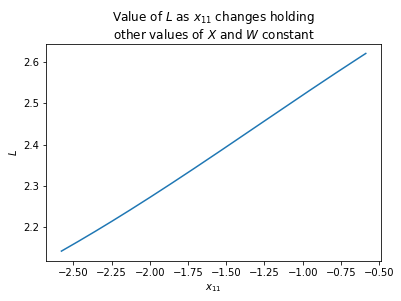

In [1158]:
plt.plot(x11s, Ls);
plt.title("Value of $L$ as $x_{11}$ changes holding\nother values of $X$ and $W$ constant")
plt.xlabel("$x_{11}$")
plt.ylabel("$L$");

# Part 2: Using this to build actual models

## Supervised Learning: the data:

Goal: build models (functions, really) like the ones we just saw that take in `ndarray`s as inputs and produce `ndarray`s as output.

For simple data: input stored in 2D `ndarray`:

$\begin{bmatrix}
x_{11} & x_{12} & x_{13} & \ldots & x_{1k} \\
x_{21} & x_{22} & x_{23} & \ldots & x_{2k} \\
x_{31} & x_{32} & x_{33} & \ldots & x_{3k}
\end{bmatrix}$

Goal is to output 1D `ndarray`:

$\begin{bmatrix}
y_{1} \\
y_{2} \\
y_{3}
\end{bmatrix}$

## Linear regression

Model usually written as:

$
\begin{equation}
y_i = \beta_0 + \beta_1 * x_1 + \ldots + \beta_n * x_k + \epsilon
\end{equation}
$

### Step 1: generating predictions

Turns out that generating the predictions for this model is the same at matrix multiplying a batch of values (ignoring the intercept):

$$
p_{batch} = X_{batch} * W = \begin{bmatrix}
x_{11} & x_{12} & x_{13} & \ldots & x_{1k} \\
x_{21} & x_{22} & x_{23} & \ldots & x_{2k} \\
x_{31} & x_{32} & x_{33} & \ldots & x_{3k}
\end{bmatrix} * \begin{bmatrix} w_1 \\ w_2 \\ w_3 \\ \vdots \\ w_k  \end{bmatrix}
=
\begin{bmatrix}
x_{11} * w_1 + x_{12} * w_2 + x_{13} * w_3 + \ldots + & x_{1k} * w_k \\
x_{21} * w_1 + x_{22} * w_2 + x_{23} * w_3 + \ldots + & x_{2k} * w_k \\
x_{31} * w_1 + x_{32} * w_2 + x_{33} * w_3 + \ldots + & x_{3k} * w_k
\end{bmatrix}
=
\begin{bmatrix}
p_1 \\
p_2 \\
p_3
\end{bmatrix}
$$

Once we generate these predictions, we'll have to compare them to an actual value $y$ to compute the loss:

### Step 2: generating the loss

$ MSE(p_{batch}, y_{batch}) = MSE(\begin{bmatrix}
p_1 \\
p_2 \\
p_3
\end{bmatrix}, \begin{bmatrix}
y_1 \\
y_2 \\
y_3
\end{bmatrix}) = \frac{(y_1 - p_1)^2 + (y_2 - p_2)^2 + (y_3 - p_3)^2}{3} $

Diagram:

<img src="img/chapter_2/01_linear_regression_simple.png" width=500>

### Adding in the intercept

### Math

We add the same number to each element of the matrix multiplication:

$$
p_{batch\_with\_bias} = x_i * W + b =
\begin{bmatrix}
x_{11} * w_1 + x_{12} * w_2 + x_{13} * w_3 + \ldots + & x_{1k} * w_k + b \\
x_{21} * w_1 + x_{22} * w_2 + x_{23} * w_3 + \ldots + & x_{2k} * w_k + b\\
x_{31} * w_1 + x_{32} * w_2 + x_{33} * w_3 + \ldots + & x_{3k} * w_k + b
\end{bmatrix}
=
\begin{bmatrix}
p_1 \\
p_2 \\
p_3
\end{bmatrix}
$$

### Diagram

<img src="img/chapter_2/02_linear_regression_with_bias.png" width=700>

### Code

In [1159]:
from typing import Dict, Tuple

def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]) -> Tuple[float, Dict[str, ndarray]]:

    # assert batch sizes of X and y are equal
    assert X.shape[0] == y.shape[0]

    # assert that matrix multiplication can work
    assert X.shape[1] == weights['W'].shape[0]

    # assert that B is simply a 1x1 ndarray
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1

    # compute the operations on the forward pass
    N = np.dot(X, weights['W'])

    #
    P = N + weights['B']

    # mean squared error loss
    loss = np.mean(np.power(y - P, 2))

    # save the information computed on the forward pass
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

## "Training" our linear regression model

The goal: compute: $ \frac{\partial \Lambda}{\partial u}(W) $ and $ \frac{\partial \Lambda}{\partial u}(B) $.

That is, how much changing $W$ and $B$ will affect the loss $L$.

But we know we can compute this using the chain rule!

### Diagram

<img src="img/chapter_2/03_linear_regression_backward.png" width=700>

Looking at the diagram, there are three partial derivatives we have to compute, that we'll then multiply together:

$$
\frac{\partial \Lambda}{\partial P}(P, Y) * \frac{\partial \alpha}{\partial N}(N, B) * \frac{\partial \nu}{\partial W}(X, W)
$$

#### Computing the backpropogation for linear regression

1. Since:

$$ \Lambda(P, Y) = (Y - P) ^ 2 $$

then 

$$ \frac{\partial \Lambda}{\partial P}(P, Y) = -1 * (2 * (Y - P)) $$


In code, this will be 

```python
dLdP = -2 * (Y - P)
```

2. Since 

$$ \alpha(N, B) = N + B $$

then

$$ \frac{\partial \alpha}{\partial N}(N, B) = 1 $$

and

$$ \frac{\partial \alpha}{\partial B}(N, B) = 1 $$



In code:

```python
dPdN = np.ones_like(N)
```

```python
dPdB = np.ones_like(B)
```

3. Since 

$$ \nu(X, W) = X * W $$

then

$$ \frac{\partial \nu}{\partial X}(X, W) = W^T $$

and

$$ \frac{\partial \nu}{\partial W}(X, W) = X^T $$

Because of the way these matrices factor out, we have to make sure to multiply $X^T$ on the right and $W^T$ on the left.

### Coding all of this up

In [1160]:
def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:

    batch_size = forward_info['X'].shape[0]

    dLdP = -2 * (forward_info['y'] - forward_info['P'])

    dPdN = np.ones_like(forward_info['N'])

    dPdB = np.ones_like(weights['B'])

    dLdN = dLdP * dPdN

    dNdW = np.transpose(forward_info['X'], (1, 0))

    # need to use matrix multiplication here,
    # with dNdW on the left (see note at the end of last chapter)
    dLdW = np.dot(dNdW, dLdN)

    # need to sum along dimension representing the batch size:
    # see note near the end of the chapter
    dLdB = (dLdP * dPdB).sum(axis=0)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB

    return loss_gradients

## Training the model

The key lines are:

```
forward_info, loss = forward_loss(X_batch, y_batch, weights)

loss_grads = loss_gradients(forward_info, weights)

for key in weights.keys():  # 'weights' and 'loss_grads' have the same keys
    weights[key] -= learning_rate * loss_grads[key]
```

### Full code

#### Reading in the data

In [1161]:
from sklearn.datasets import load_boston

boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

In [1162]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [1163]:
def to_2d_np(a: ndarray, 
          type: str="col") -> ndarray:
    '''
    Turns a 1D Tensor into 2D
    '''

    assert a.ndim == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":        
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [1164]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

# make target 2d array
y_train, y_test = to_2d_np(y_train), to_2d_np(y_test)

#### Helper functions

In [1165]:
def permute_data(X, y):
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [1166]:
Batch = Tuple[ndarray, ndarray]

def generate_batch(X: ndarray, 
                   y: ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    
    assert X.ndim == y.ndim == 2, \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [1167]:
def init_weights(n_in) -> Dict[str, ndarray]:
    
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B

    return weights

In [1168]:
def train(X: ndarray, 
          y: ndarray, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:

    if seed:
        np.random.seed(seed)

    start = 0

    # Initialize weights
    weights = init_weights(X.shape[1])

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        # Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)
        
        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, weights
    
    return None

### Actual training code

In [1169]:
train_info = train(X_train, y_train,
                   n_iter = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

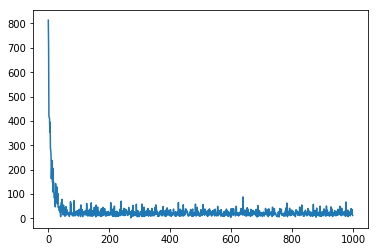

In [1170]:
plt.plot(list(range(1000)), losses);

In [1171]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]):

    N = np.dot(X, weights['W'])

    return N + weights['B']

In [1172]:
preds = predict(X_test, weights)

#### "Mean absolute error"

In [1173]:
np.round(np.mean(np.abs(preds - y_test)), 4)

3.5643

#### "Root mean squared error"

In [1174]:
np.round(np.sqrt(np.mean(np.power(preds - y_test, 2))), 4)

5.0508

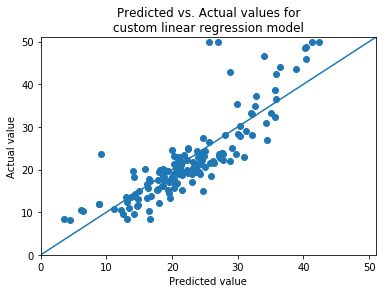

In [1175]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

### Comparing to a `SciKit Learn` Linear Regression

In [1176]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

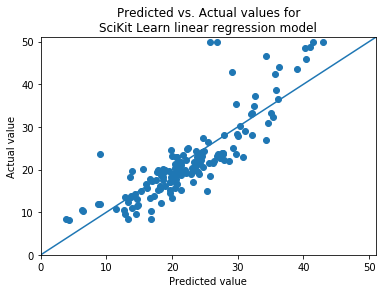

In [1177]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\nSciKit Learn linear regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

About the same

#### Error metrics:

In [1178]:
np.round(np.mean(np.abs(preds - y_test)), 4)

3.5666

In [1179]:
np.round(np.sqrt(np.mean(np.power(preds - y_test, 2))), 4)

5.0482

### Coefficients are the same too:

In [1180]:
# SciKit Learn LR
np.round(lr.coef_, 2), np.round(lr.intercept_, 2)

(array([[-1.01,  0.71,  0.28,  0.71, -2.21,  2.37,  0.72, -2.66,  2.63,
         -1.82, -2.33,  0.86, -4.2 ]]), array([22.62]))

In [1181]:
# Custom LR
np.round(weights['W'].reshape(-1), 2), np.round(weights['B'].reshape(-1), 2)

(array([-1.09,  0.73,  0.2 ,  0.75, -2.29,  2.19,  0.72, -2.64,  2.53,
        -1.69, -2.32,  0.85, -4.26]), array([22.63]))

## Neural network from scratch

With a neural network, we:

* First do _many_ "linear regressions". Here, we have a dataset with 13 features, so we'll somewhat arbitrarily do 13 linear regressions.
* Then, feed these through some non-linear function; we'll use the sigmoid function for this.
* Finally, feed the results of all of these through a final linear regression to get our predictions.

<img src="img/chapter_2/04_neural_network_forward_pass.png" width=700>

This is equivalent to the more conventional representation:

<img src="img/chapter_2/05_neural_network_representation_2.png" width=400>

### Coding this up

Importantly: **the training procedure for this model (as well as the future models we're going to see) is the same!**

* We'll go forward through a series of operations, saving the results in `forward_info`.
* We'll define a `loss_gradients` function that computes the gradients of the loss with respect to the weights.
* We'll still use the following lines of code in the `train` function:

```python
forward_info, loss = forward_loss(X_batch, y_batch, weights)

loss_grads = loss_gradients(forward_info, weights)

for key in weights.keys():
    weights[key] -= learning_rate * loss_grads[key]
```

In [1182]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]) -> Tuple[Dict[str, ndarray], float]:

    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)

    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['M1'] = M1
    forward_info['N1'] = N1
    forward_info['O1'] = O1
    forward_info['M2'] = M2
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [1183]:
def init_weights(input_size: int, 
                 hidden_size: int) -> Dict[str, ndarray]:
    
    weights: Dict[str, ndarray] = {}
    weights['W1'] = np.random.randn(input_size, hidden_size)
    weights['B1'] = np.random.randn(1, hidden_size)
    weights['W2'] = np.random.randn(hidden_size, 1)
    weights['B2'] = np.random.randn(1, 1)
    return weights

In [1184]:
def loss_gradients(forward_info: Dict[str, ndarray], 
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    
    dLdP = -(forward_info['y'] - forward_info['P'])
    
    dPdM2 = np.ones_like(forward_info['M2'])

    dLdM2 = dLdP * dPdM2
  
    dPdB2 = np.ones_like(weights['B2'])

    dLdB2 = (dLdP * dPdB2).sum(axis=0)
    
    dM2dW2 = np.transpose(forward_info['O1'], (1, 0))
    
    dLdW2 = np.dot(dM2dW2, dLdP)

    dM2dO1 = np.transpose(weights['W2'], (1, 0)) 

    dLdO1 = np.dot(dLdM2, dM2dO1)
    
    dO1dN1 = sigmoid(forward_info['N1']) * (1 - sigmoid(forward_info['N1']))
    
    dLdN1 = dLdO1 * dO1dN1
    
    dN1dB1 = np.ones_like(weights['B1'])
    
    dN1dM1 = np.ones_like(forward_info['M1'])
    
    dLdB1 = (dLdN1 * dN1dB1).sum(axis=0)
    
    dLdM1 = dLdN1 * dN1dM1
    
    dM1dW1 = np.transpose(forward_info['X'], (1, 0)) 

    dLdW1 = np.dot(dM1dW1, dLdM1)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W2'] = dLdW2
    loss_gradients['B2'] = dLdB2.sum(axis=0)
    loss_gradients['W1'] = dLdW1
    loss_gradients['B1'] = dLdB1.sum(axis=0)
    
    return loss_gradients

In [1185]:
def predict(X: ndarray, 
            weights: Dict[str, ndarray]):
    
    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)
    
    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']    

    return P

In [1186]:
def train(X_train: ndarray, y_train: ndarray,
          X_test: ndarray, y_test: ndarray,
          n_iter: int = 1000,
          test_every: int = 1000,
          learning_rate: float = 0.01,
          hidden_size= 13,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          return_scores: bool = False,
          seed: int = 1) -> None:

    if seed:
        np.random.seed(seed)
    start = 0

    # Initialize weights
    weights = init_weights(X_train.shape[1], 
                           hidden_size=hidden_size)

    # Permute data
    X_train, y_train = permute_data(X_train, y_train)
    

    losses = []
        
    val_scores = []

    for i in range(n_iter):

        # Generate batch
        if start >= X_train.shape[0]:
            X_train, y_train = permute_data(X_train, y_train)
            start = 0
        
        X_batch, y_batch = generate_batch(X_train, y_train, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
        
        if return_scores:
            if i % test_every == 0 and i != 0:
                preds = predict(X_test, weights)
                val_scores.append(r2_score(preds, y_test))

    if return_weights:
        return losses, weights, val_scores
    
    return None

In [1187]:
train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=10000,
                   test_every = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   return_scores=False,
                   seed=180807)
losses = train_info[0]
weights = train_info[1]

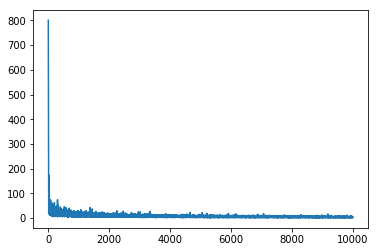

In [1188]:
plt.plot(list(range(10000)), losses);

In [1189]:
preds = predict(X_test, weights)

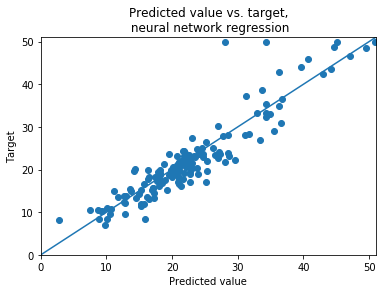

In [1190]:
plt.xlabel("Predicted value")
plt.ylabel("Target")
plt.title("Predicted value vs. target,\n neural network regression")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

#### Error metrics

In [1191]:
np.round(np.mean(np.abs(preds - y_test)), 4)

2.5289

In [1192]:
np.round(np.sqrt(np.mean(np.power(preds - y_test, 2))), 4)

3.6775

Significantly lower than before!

# Deep Learning From Scratch

Clearly we need a different approach to tackle Deep Learning models. Backpropogation in this model took 17 individual steps!

We're going to switch to using an object oriented framework for our more complex Deep Learning models.

Based on how we've been coding this up, the fundamental building block will be an `Operation`. 

## `Operation` blueprint

An `Operation` will:

* Have a `forward` method that takes an `ndarray`, **`input_`** as input and outputs an `ndarray` **`output`** as output.
* Have a `backward` method that takes an `ndarray` **`output_grad`** as input and outputs an `ndarray` **`input_grad`** as output. 

Furthermore, we'll need to check a couple things:

* `input_` should have the same shape as `input_grad`
* `output` should have the same shape as `output_grad`

### Diagram

<img src="img/chapter_3/01_operation_input_output.png" width=600>

In [1193]:
def assert_same_shape(array: ndarray,
                      array_grad: ndarray):
    assert array.shape == array_grad.shape, \
        '''
        Two tensors should have the same shape;
        instead, first Tensor's shape is {0}
        and second Tensor's shape is {1}.
        '''.format(tuple(array_grad.shape), tuple(array.shape))
    return None


In [1194]:
class Operation(object):

    def __init__(self):
        pass

    def forward(self,
                input_: ndarray):
        self.input_ = input_

        self.output = self._output()

        return self.output


    def backward(self, output_grad: ndarray) -> ndarray:

        assert_same_shape(self.output, output_grad)

        self.input_grad = self._input_grad(output_grad)

        assert_same_shape(self.input_, self.input_grad)
        return self.input_grad


    def _output(self) -> ndarray:
        raise NotImplementedError()


    def _input_grad(self, output_grad: ndarray) -> ndarray:
        raise NotImplementedError()

## `ParamOperation` subclass

<img src="img/chapter_3/02_operation_with_params.png" width=600>

In [1195]:
class ParamOperation(Operation):

    def __init__(self, param: ndarray) -> ndarray:
        super().__init__()
        self.param = param

    def backward(self, output_grad: ndarray) -> ndarray:

        assert_same_shape(self.output, output_grad)

        self.input_grad = self._input_grad(output_grad)
        self.param_grad = self._param_grad(output_grad)

        assert_same_shape(self.input_, self.input_grad)

        return self.input_grad

    def _param_grad(self, output_grad: ndarray) -> ndarray:
        raise NotImplementedError()

## Implementing the operations from the prior chapters

In [1196]:
class WeightMultiply(ParamOperation):

    def __init__(self, W: ndarray):
        super().__init__(W)

    def _output(self) -> ndarray:
        return np.dot(self.input_, self.param)

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        return np.dot(output_grad, np.transpose(self.param, (1, 0)))

    def _param_grad(self, output_grad: ndarray) -> ndarray:
        return np.dot(np.transpose(self.input_, (1, 0)), output_grad)

In [1197]:
class BiasAdd(ParamOperation):

    def __init__(self,
                 B: ndarray):
        
        assert B.shape[0] == 1
        
        super().__init__(B)

    def _output(self) -> ndarray:
        
        # self.input.shape[1] == self.param.shape[1]
        return self.input_ + self.param

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        
        # self.input.shape[1] == self.param.shape[1]
        return np.ones_like(self.input_) * output_grad

    def _param_grad(self, output_grad: ndarray) -> ndarray:
        param_grad = np.ones_like(self.param) * output_grad
        return np.sum(param_grad, axis=0).reshape(1, param_grad.shape[1])

### A non-linear operation

In [1198]:
class Sigmoid(Operation):

    def __init__(self) -> None:
        super().__init__()

    def _output(self) -> ndarray:
        return 1.0/(1.0+np.exp(-1.0 * self.input_))

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        sigmoid_backward = self.output * (1.0 - self.output)
        input_grad = sigmoid_backward * output_grad
        return input_grad

#### Defining a "linear" or "identity" activation (we'll need this for the last layer)

In [1199]:
class Linear(Operation):

    def __init__(self) -> None:
        super().__init__()

    def _output(self) -> ndarray:
        return self.input_

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        return output_grad

## On "Layers"

You've probably heard neural networks described as being made up of layers. What does this mean?

A layer, using the framework we've been building up here, is simply **a series of linear operations (e.g. weight multiplication) followed by a non-linear operation**.

Thus, a `Layer` will:

* Pass data forward through a series of `Operation`s
* Pass data backward through the same `Operation`s

In [1200]:
class Layer(object):

    def __init__(self,
                 neurons: int) -> None:
        self.neurons = neurons
        self.first = True
        self.params: List[ndarray] = []
        self.param_grads: List[ndarray] = []
        self.operations: List[Operation] = []

    def _setup_layer(self, num_in: int) -> None:
        pass

    def forward(self, input_: ndarray) -> ndarray:
        if self.first:
            self._setup_layer(input_)
            self.first = False

        self.input_ = input_

        for operation in self.operations:

            input_ = operation.forward(input_)

        self.output = input_

        return self.output

    def backward(self, output_grad: ndarray) -> ndarray:

        assert_same_shape(self.output, output_grad)

        for operation in reversed(self.operations):
            output_grad = operation.backward(output_grad)

        input_grad = output_grad
        
        self._param_grads()

        return input_grad

    def _param_grads(self) -> ndarray:

        self.param_grads = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.param_grads.append(operation.param_grad)

    def _params(self) -> ndarray:

        self.params = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.params.append(operation.param)
        

### Mapping the diagram we had of `Operation`s to `Layer`s:

<img src="img/chapter_3/03_neural_network_layers.png" width=700>

### Implementing the `Layer` we've been looking at so far

In [1201]:
class Dense(Layer):
    '''
    Once we define all the Operations and the outline of a layer, all that remains to implement here
    is the _setup_layer function!
    '''
    def __init__(self,
                 neurons: int,
                 activation: Operation = Sigmoid()) -> None:
        super().__init__(neurons)
        self.activation = activation

    def _setup_layer(self, input_: ndarray) -> None:
        if self.seed:
            np.random.seed(self.seed)

        self.params = []

        # weights
        self.params.append(np.random.randn(input_.shape[1], self.neurons))

        # bias
        self.params.append(np.random.randn(1, self.neurons))

        self.operations = [WeightMultiply(self.params[0]),
                           BiasAdd(self.params[1]),
                           self.activation]

        return None

### A special kind of layer/operation: the `Loss`

In [1202]:
class Loss(object):

    def __init__(self):
        pass

    def forward(self, prediction: ndarray, target: ndarray) -> float:

        assert_same_shape(prediction, target)

        self.prediction = prediction
        self.target = target

        loss_value = self._output()

        return loss_value

    def backward(self) -> ndarray:

        self.input_grad = self._input_grad()

        assert_same_shape(self.prediction, self.input_grad)

        return self.input_grad

    def _output(self) -> float:
        raise NotImplementedError()

    def _input_grad(self) -> ndarray:
        raise NotImplementedError()

### The `MeanSquaredError` loss we've been using

In [1203]:
class MeanSquaredError(Loss):

    def __init__(self) -> None:
        super().__init__()

    def _output(self) -> float:

        loss = np.sum(np.power(self.prediction - self.target, 2)) / self.prediction.shape[0]

        return loss

    def _input_grad(self) -> ndarray:

        return 2.0 * (self.prediction - self.target) / self.prediction.shape[0]

## Finally: a `NeuralNetwork` class

What will our `NeuralNetwork` class do? Mostly, just: pass data forward between a series of layers!

In [1204]:
class NeuralNetwork(object):

    def __init__(self, layers: List[Layer],
                 loss: Loss,
                 seed: float = 1) -> None:
        self.layers = layers
        self.loss = loss
        self.seed = seed
        if seed:
            for layer in self.layers:
                setattr(layer, "seed", self.seed)        

    def forward(self, x_batch: ndarray) -> ndarray:

        x_out = x_batch
        for layer in self.layers:
            x_out = layer.forward(x_out)

        return x_out

    def batch_loss(self,
                   prediction: ndarray,
                   y_batch: ndarray) -> ndarray:

        return self.loss.loss_gradient(prediction, y_batch)

    def backward(self, loss_grad: ndarray) -> None:

        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

        return None

    def train_batch(self,
                    x_batch: ndarray,
                    y_batch: ndarray) -> float:

        predictions = self.forward(x_batch)

        loss = self.loss.forward(predictions, y_batch)

        self.backward(self.loss.backward())

        return loss
    
    def params(self):
        for layer in self.layers:
            yield from layer.params

    def param_grads(self):
        for layer in self.layers:
            yield from layer.param_grads    

# Two additional classes: `Optimizer` and `Trainer`

The `Optimizer` will use those `.params()` and `.param_grads()` methods to handle the actual updating of the neural network's weights.

In [1250]:
class Optimizer(object):
    def __init__(self,
                 lr: float = 0.01):
        self.lr = lr

    def step(self) -> None:
        pass

In [1251]:
class SGD(Optimizer):
    def __init__(self,
                 lr: float = 0.01) -> None:
        super().__init__(lr)

    def step(self):
        for (param, param_grad) in zip(self.net.params(),
                                       self.net.param_grads()):
#             import pdb; pdb.set_trace()
            param -= self.lr * param_grad

The `Trainer` will train the model:

In [1043]:
from copy import deepcopy

class Trainer(object):
    '''
    Just a list of layers that runs forwards and backwards
    '''
    def __init__(self,
                 net: NeuralNetwork,
                 optim: Optimizer) -> None:
        self.net = net
        self.optim = optim
        self.best_loss = 1e9
        setattr(self.optim, 'net', self.net)
        
    def generate_batches(self,
                         X: ndarray,
                         y: ndarray,
                         size: int = 32) -> Tuple[ndarray]:

        assert X.shape[0] == y.shape[0], \
        '''
        features and target must have the same number of rows, instead
        features has {0} and target has {1}
        '''.format(X.shape[0], y.shape[0])

        N = X.shape[0]

        for ii in range(0, N, size):
            X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]

            yield X_batch, y_batch

            
    def fit(self, X_train: ndarray, y_train: ndarray,
            X_test: ndarray, y_test: ndarray,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            seed: int = 1,
            restart: bool = True)-> None:


        np.random.seed(seed)
        if restart:
            for layer in self.net.layers:
                layer.first = True

            self.best_loss = 1e9

        for e in range(epochs):

            if (e+1) % eval_every == 0:
                
                # for early stopping
                last_model = deepcopy(self.net)

            X_train, y_train = permute_data(X_train, y_train)

            batch_generator = self.generate_batches(X_train, y_train,
                                                    batch_size)

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                self.net.train_batch(X_batch, y_batch)

                self.optim.step()

            if (e+1) % eval_every == 0:

                test_preds = self.net.forward(X_test)
                loss = self.net.loss.forward(test_preds, y_test)

                if loss < self.best_loss:
                    print(f"Validation loss after {e+1} epochs is {loss:.3f}")
                    self.best_loss = loss
                else:
                    print(f"""Loss increased after epoch {e+1}, final loss was {self.best_loss:.3f}, using the model from epoch {e+1-eval_every}""")
                    self.net = last_model
                    # ensure self.optim is still updating self.net
                    setattr(self.optim, 'net', self.net)
                    break

### (last thing!) evaluation functions:

In [1061]:
def mae(y_true: ndarray, y_pred: ndarray):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true: ndarray, y_pred: ndarray):
    return np.sqrt(np.mean(np.power(y_true - y_pred, 2)))

def eval_regression_model(model: NeuralNetwork,
                          X_test: ndarray,
                          y_test: ndarray):
    preds = model.forward(X_test)
    preds = preds.reshape(-1, 1)
    print("Mean absolute error: {:.2f}".format(mae(preds, y_test)))
    print()
    print("Root mean squared error {:.2f}".format(rmse(preds, y_test)))

### (finally) defining some real models!

In [1236]:
lr = NeuralNetwork(
    layers=[Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

nn = NeuralNetwork(
    layers=[Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

dl = NeuralNetwork(
    layers=[Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

In [1237]:
trainer = Trainer(lr, SGD(lr=0.01))

trainer.fit(X_train, y_train, X_test, y_test,
       epochs = 50,
       eval_every = 10,
       seed=20190501);
print()
eval_regression_model(lr, X_test, y_test)

Validation loss after 10 epochs is 30.295
Validation loss after 20 epochs is 28.462
Validation loss after 30 epochs is 26.299
Validation loss after 40 epochs is 25.548
Validation loss after 50 epochs is 25.092

Mean absolute error: 3.52

Root mean squared error 5.01


In [1238]:
trainer = Trainer(nn, SGD(lr=0.01))
trainer.fit(X_train, y_train, X_test, y_test,
       epochs = 50,
       eval_every = 10,
       seed=20190501);

print()
eval_regression_model(nn, X_test, y_test)

Validation loss after 10 epochs is 27.434
Validation loss after 20 epochs is 21.834
Validation loss after 30 epochs is 18.915
Validation loss after 40 epochs is 17.193
Validation loss after 50 epochs is 16.214

Mean absolute error: 2.60

Root mean squared error 4.03


In [1239]:
trainer = Trainer(dl, SGD(lr=0.01))

trainer.fit(X_train, y_train, X_test, y_test,
       epochs = 50,
       eval_every = 10,
       seed=20190501);

print()
eval_regression_model(dl, X_test, y_test)

Validation loss after 10 epochs is 44.134
Validation loss after 20 epochs is 25.271
Validation loss after 30 epochs is 22.341
Validation loss after 40 epochs is 16.464
Validation loss after 50 epochs is 14.604

Mean absolute error: 2.45

Root mean squared error 3.82


We finally did Deep Learning From Scratch!

Of course, we could optimize this by changing the learning rate or number of epochs. However, let's explore some more substantial changes to this learning procedure.

# Deep Learning Optimizations

We'll cover:

* Different loss functions
* Learning rate decay
* Other optimizers (momentum)
* Proper weight initialization
* Dropout

We'll do all this on the MNIST dataset.

In [1240]:
# CODE TAKEN FROM HERE: https://github.com/hsjeong5/MNIST-for-Numpy

import numpy as np
from urllib import request
import gzip
import pickle

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def mnist_init():
    download_mnist()
    save_mnist()

def mnist_load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]



In [1241]:
mnist_init()
X_train, y_train, X_test, y_test = mnist_load()

Download complete.
Save complete.


In [1242]:
# One hot encoded versions of labels
num_labels = len(y_train)
train_labels = np.zeros((num_labels, 10))
for i in range(num_labels):
    train_labels[i][y_train[i]] = 1

num_labels = len(y_test)
test_labels = np.zeros((num_labels, 10))
for i in range(num_labels):
    test_labels[i][y_test[i]] = 1

In [1243]:
X_train, X_test = X_train - np.mean(X_train), X_test - np.mean(X_train)

In [1244]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(-33.318421449829934,
 221.68157855017006,
 -33.318421449829934,
 221.68157855017006)

In [1245]:
X_train, X_test = X_train / np.std(X_train), X_test / np.std(X_train)

In [1095]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(-0.424073894391566, 2.821543345689335, -0.424073894391566, 2.821543345689335)

In [1111]:
def calc_accuracy_model(model, test_set):
    return print(f'''The model validation accuracy is: 
    {np.equal(np.argmax(model.forward(test_set), axis=1), y_test).sum() * 100.0 / test_set.shape[0]:.2f}%''')

## Softmax cross entropy loss function

A very important loss function for classification problems that has two components:

### Component #1: the softmax function

Normally neural networks output, for each observation in a classification problem, simply a vector of numbers equal to the number of classes in that problem:

```python
[5, 3, 2]
```

One way to "normalize" these to be probabilities is to simply divide by their sum:

```python
[0.5, 0.3, 0.2]
```

Another way is to divide by the softmax function:

$ \text{Softmax}(\begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix})  = \begin{bmatrix} \frac{e^{x_1}}{e^{x_1} + e^{x_2} + e^{x_3}} \\
\frac{e^{x_2}}{e^{x_1} + e^{x_2} + e^{x_3}} \\
\frac{e^{x_3}}{e^{x_1} + e^{x_2} + e^{x_3}}
\end{bmatrix} $

It turns out, for reasons we won't go into, a numerically stable, concise way to implement this is:

In [1101]:
from scipy.special import logsumexp

def softmax(x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))

In [1102]:
softmax(np.array([5, 3, 2]))

array([0.8438, 0.1142, 0.042 ])

Note that the maximum value is "amplified".

### Component #2: cross entropy loss

The cross entropy between two vectors $p_i$ and $y_i$ can be defined as:

$$
\text{CE}(p_i, y_i) = - y_i * \text{log}(p_i) - (1 - y_i) * \text{log}(1-p_i)
$$

which is equivalent to:

$$
\text{CE}(p_i,y_i)=
\begin{cases}
-log(1-p_i) & \text{if }  y_i = 0\\
-log(p_i) & \text{if }  y_i = 1
\end{cases}
$$

#### Intuition for cross entropy loss:

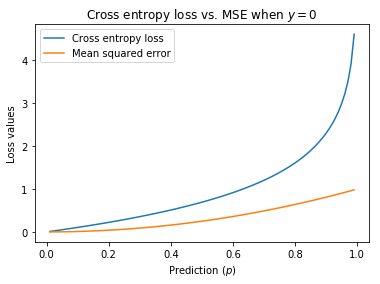

In [1103]:
x = np.linspace(0.01, 0.99, 99)
y1 = -1.0 * np.log(1 - x)
y2 = (x - 0) ** 2
plt.plot(x, y1);
plt.plot(x, y2);
plt.legend(['Cross entropy loss', 'Mean squared error'])

plt.title("Cross entropy loss vs. MSE when $y = 0$")
plt.xlabel("Prediction ($p$)")
plt.ylabel("Loss values");
plt.savefig("Log_loss_vs_MSE_y_eq_0.png")

**The "softmax cross entropy loss" combines these two!** For example, in the case where there are three classes with probabilities $p_1$, $p_2$, and $p_3$, we have:

$$
\text{SCE}(p_i, y_i) = - y_i * \text{log}(\frac{e^{p_i}}{e^{p_1} + e^{p_2} + e^{p_3}}) - (1 - y_i) * \text{log}(1-\frac{e^{p_i}}{e^{p_1} + e^{p_2} + e^{p_3}})
$$


Furthermore, this function has an extremely elegant gradient:

$$ \frac{\partial {SCE}_1}{\partial p_1} = \frac{e^{p_1}}{e^{p_1} + e^{p_2} + e^{p_3}} - y_1 $$

In code, this will simply be:

```python
softmax_x = softmax(x, axis = 1) 

loss_grad = softmax_x - y
```

### Full code

In [1121]:
class SoftmaxCrossEntropyLoss(Loss):
    def __init__(self, eps: float=1e-9) -> None:
        super().__init__()
        self.eps = eps

    def _output(self) -> float:

        # applying the softmax function to each row (observation)
        softmax_preds = softmax(self.prediction, axis=1)

        # clipping the softmax output to prevent numeric instability
        self.softmax_preds = np.clip(softmax_preds, self.eps, 1 - self.eps)

        # actual loss computation
        softmax_cross_entropy_loss = -1.0 * self.target * np.log(self.softmax_preds) - \
            (1.0 - self.target) * np.log(1 - self.softmax_preds)

        return np.sum(softmax_cross_entropy_loss) / self.softmax_preds.shape[0]

    def _input_grad(self) -> ndarray:

        return (self.softmax_preds - self.target) / self.softmax_preds.shape[0]

### MNIST Experiment

Note: throughout these experiments, we'll be using the Tanh activation function, rather than sigmoid.

In [1122]:
class Tanh(Operation):
    '''
    Hyperbolic tangent activation function
    '''
    def __init__(self) -> None:
        super().__init__()

    def _output(self) -> ndarray:
        return np.tanh(self.input_)

    def _input_grad(self, output_grad: ndarray) -> ndarray:

        return output_grad * (1 - self.output * self.output)

In [1246]:
model = NeuralNetwork(
    layers=[Dense(neurons=89,
                  activation=Tanh()),
            Dense(neurons=10,
                  activation=Sigmoid())],
            loss = MeanSquaredError(),
    seed=20190501,
)

optimizer = SGD(0.1)

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190501,
            batch_size=60);

calc_accuracy_model(model, X_test)

Validation loss after 10 epochs is 0.538
Validation loss after 20 epochs is 0.431
Validation loss after 30 epochs is 0.387
Validation loss after 40 epochs is 0.372
Validation loss after 50 epochs is 0.364
The model validation accuracy is: 
    72.67%


In [1247]:
model = NeuralNetwork(
    layers=[Dense(neurons=89,
                  activation=Tanh()),
            Dense(neurons=10,
                  activation=Linear())],
            loss = SoftmaxCrossEntropyLoss(),
    seed=20190501
)

optimizer = SGD(0.1)

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190501,
            batch_size=60);

calc_accuracy_model(model, X_test)

Validation loss after 10 epochs is 0.619
Validation loss after 20 epochs is 0.555
Validation loss after 30 epochs is 0.537
Validation loss after 40 epochs is 0.529
Validation loss after 50 epochs is 0.529
The model validation accuracy is: 
    90.89%


## Momentum

### Motivation

Fundamentally, neural networks are trying to find the minimum of a function via gradient descent or "descending down a hill".

<img src="img/chapter_4/03_weight_update_vs_loss.png" width=600>

The weights can be thought of as balls rolling down a hill. In the real world, objects like this have **momentum**: their instantaneous rate of change or "velocity" is a function both of the current forces acting on them and their past velocities.

Turns out we want the weight update at time $t$ to be:

$$
\text{update} = \nabla_t + \mu * \nabla_{t-1} + \mu^2 * \nabla_{t-2} + \ldots
$$

Where $\mu$ is a "momentum" or "decay" parameter.

How do we implement this?

Turns out we can use the following steps at each time step:

1. Multiply it by the momentum parameter
2. Add the gradient

This results in the following weight updates:

1. $ \nabla_1 $
2. $ \nabla_2 + \mu * \nabla_1 $
3. $ \nabla_3 + \mu * (\nabla_2 + \mu * \nabla_1) = \mu * \nabla_2 + \mu^2 * \nabla_1 $

### Coding this up

In [1258]:
class SGDMomentum(Optimizer):
    def __init__(self,
                 lr: float = 0.01,
                 momentum: float = 0.9) -> None:
        super().__init__(lr)
        self.momentum = momentum
        self.first = True

    def step(self) -> None:
        if self.first:
            self.velocities = [np.zeros_like(param)
                               for param in self.net.params()]
            self.first = False

        for (param, param_grad, velocity) in zip(self.net.params(),
                                                 self.net.param_grads(),
                                                 self.velocities):
            self._update_rule(param=param,
                              grad=param_grad,
                              velocity=velocity)

    def _update_rule(self, **kwargs) -> None:

            # Update velocity
            kwargs['velocity'] *= self.momentum
            kwargs['velocity'] += self.lr * kwargs['grad']

            # Use this to update parameters
            kwargs['param'] -= kwargs['velocity']

In [1259]:
model = NeuralNetwork(
    layers=[Dense(neurons=89,
                  activation=Tanh()),
            Dense(neurons=10,
                  activation=Linear())],
            loss = SoftmaxCrossEntropyLoss(),
    seed=20190501
)

optimizer = SGDMomentum(0.1, momentum=0.9)

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190501,
            batch_size=60);

calc_accuracy_model(model, X_test)

Validation loss after 10 epochs is 0.403
Validation loss after 20 epochs is 0.356
Validation loss after 30 epochs is 0.333
Loss increased after epoch 40, final loss was 0.333, using the model from epoch 30
The model validation accuracy is: 
    95.46%


## Learining rate decay

Again, neural networks are trying to find the minimum of a function:

<img src="img/chapter_4/03_weight_update_vs_loss.png" width=600>

Intuitively, at the beginning of the training process, we can take larger steps, but as we get closer to the minimum, we want the steps to automatically get smaller.

### Implementation

We want to allow the learning rate can decay from some starting value, to an ending value, with the decay happening either linearly or exponentially.

#### Linear decay

$$ \alpha_{t} = \alpha_{start} - (\alpha_{start} - \alpha_{end}) * \frac{t}{N} $$

#### Exponential decay

$$ \alpha_{t} = \alpha_{start} * ((\frac{\alpha_{end}}{\alpha_{start}})^\frac{1}{N})^t $$

### Code

In [1265]:
class Optimizer(object):
    def __init__(self,
                 lr: float = 0.01,
                 final_lr: float = 0,
                 decay_type: str = None) -> None:
        self.lr = lr
        self.final_lr = final_lr  
        self.decay_type = decay_type
        self.first = True

    def _setup_decay(self) -> None:

        if not self.decay_type:
            return
        elif self.decay_type == 'exponential':
            self.decay_per_epoch = np.power(self.final_lr / self.lr,
                                       1.0 / self.max_epochs)
        elif self.decay_type == 'linear':
            self.decay_per_epoch = (self.lr - self.final_lr) / self.max_epochs

    def _decay_lr(self) -> None:

        if not self.decay_type:
            return

        if self.decay_type == 'exponential':
            self.lr *= self.decay_per_epoch

        elif self.decay_type == 'linear':
            self.lr -= self.decay_per_epoch

    def step(self,
             epoch: int = 0) -> None:

        for (param, param_grad) in zip(self.net.params(),
                                       self.net.param_grads()):
            self._update_rule(param=param,
                              grad=param_grad)

    def _update_rule(self, **kwargs) -> None:
        raise NotImplementedError()


In [1261]:
class SGDMomentum(Optimizer):
    def __init__(self,
                 lr: float = 0.01,
                 final_lr: float = 0,
                 decay_type: str = None,
                 momentum: float = 0.9) -> None:
        super().__init__(lr, final_lr, decay_type)
        self.momentum = momentum

    def step(self) -> None:
        if self.first:
            self.velocities = [np.zeros_like(param)
                               for param in self.net.params()]
            self.first = False

        for (param, param_grad, velocity) in zip(self.net.params(),
                                                 self.net.param_grads(),
                                                 self.velocities):
            self._update_rule(param=param,
                              grad=param_grad,
                              velocity=velocity)

    def _update_rule(self, **kwargs) -> None:

            # Update velocity
            kwargs['velocity'] *= self.momentum
            kwargs['velocity'] += self.lr * kwargs['grad']

            # Use this to update parameters
            kwargs['param'] -= kwargs['velocity']

In [1266]:
class Trainer(object):
    '''
    Just a list of layers that runs forwards and backwards
    '''
    def __init__(self,
                 net: NeuralNetwork,
                 optim: Optimizer) -> None:
        self.net = net
        self.optim = optim
        self.best_loss = 1e9
        setattr(self.optim, 'net', self.net)
        
    def generate_batches(self,
                         X: ndarray,
                         y: ndarray,
                         size: int = 32) -> Tuple[ndarray]:

        assert X.shape[0] == y.shape[0], \
        '''
        features and target must have the same number of rows, instead
        features has {0} and target has {1}
        '''.format(X.shape[0], y.shape[0])

        N = X.shape[0]

        for ii in range(0, N, size):
            X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]

            yield X_batch, y_batch

            
    def fit(self, X_train: ndarray, y_train: ndarray,
            X_test: ndarray, y_test: ndarray,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            seed: int = 1,
            restart: bool = True)-> None:

        setattr(self.optim, 'max_epochs', epochs)
        self.optim._setup_decay()
        
        np.random.seed(seed)
        if restart:
            for layer in self.net.layers:
                layer.first = True

            self.best_loss = 1e9

        for e in range(epochs):

            if (e+1) % eval_every == 0:
                
                # for early stopping
                last_model = deepcopy(self.net)

            X_train, y_train = permute_data(X_train, y_train)

            batch_generator = self.generate_batches(X_train, y_train,
                                                    batch_size)

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                self.net.train_batch(X_batch, y_batch)

                self.optim.step()

            if (e+1) % eval_every == 0:

                test_preds = self.net.forward(X_test)
                loss = self.net.loss.forward(test_preds, y_test)

                if loss < self.best_loss:
                    print(f"Validation loss after {e+1} epochs is {loss:.3f}")
                    self.best_loss = loss
                else:
                    print(f"""Loss increased after epoch {e+1}, final loss was {self.best_loss:.3f}, using the model from epoch {e+1-eval_every}""")
                    self.net = last_model
                    # ensure self.optim is still updating self.net
                    setattr(self.optim, 'net', self.net)
                    break
                    
            if self.optim.final_lr:
                self.optim._decay_lr()

In [1267]:
model = NeuralNetwork(
    layers=[Dense(neurons=89,
                  activation=Tanh()),
            Dense(neurons=10,
                  activation=Linear())],
            loss = SoftmaxCrossEntropyLoss(),
    seed=20190501
)

optimizer = SGDMomentum(0.2, momentum=0.9, final_lr=0.05, decay_type='exponential')

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190501,
            batch_size=60);

calc_accuracy_model(model, X_test)

Validation loss after 10 epochs is 0.408
Validation loss after 20 epochs is 0.323
Validation loss after 30 epochs is 0.283
Loss increased after epoch 40, final loss was 0.283, using the model from epoch 30
The model validation accuracy is: 
    96.20%


In [1268]:
model = NeuralNetwork(
    layers=[Dense(neurons=89,
                  activation=Tanh()),
            Dense(neurons=10,
                  activation=Linear())],
            loss = SoftmaxCrossEntropyLoss(),
    seed=20190501
)

optimizer = SGDMomentum(0.2, momentum=0.9, final_lr=0.05, decay_type='linear')

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190501,
            batch_size=60);

calc_accuracy_model(model, X_test)

Validation loss after 10 epochs is 0.451
Validation loss after 20 epochs is 0.330
Validation loss after 30 epochs is 0.301
Loss increased after epoch 40, final loss was 0.301, using the model from epoch 30
The model validation accuracy is: 
    95.73%


## Weight initialization